<a href="https://colab.research.google.com/github/heyroha/DL/blob/main/TF/TF2_%EC%B5%9C%EC%A0%81%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 최적화

## 1.자동미분

- 텐서플로우의 자동 미분
```tf.GradientTape```
- tf.GradientTape 은 컨텍스트 안에서 실행된 모든 연산을 테이프에 기록
- 그 다음 텐서플로는 후진 방식 자동 미분을 사용해 테이프에 기록된 연산의 그래디언트를 계산

- scalar를 scalar로 미분

In [ ]:
import tensorflow as tf
x = tf.Variable(3.0)
x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>

In [ ]:
with tf.GradientTape() as tape:
  y = x ** 2

In [ ]:
y

<tf.Tensor: shape=(), dtype=float32, numpy=9.0>

In [ ]:
# dy = 2x * dy
dy_dx = tape.gradient(y,x)
dy_dx.numpy()

6.0

- scalar를 vector로 미분

In [ ]:
w = tf.Variable(tf.random.normal((3,2)), name = 'w')
b = tf.Variable(tf.zeros(2, dtype = tf.float32), name = 'b')
x = [[1.,2.,3.]]

with tf.GradientTape(persistent = True) as tape:
  y = x@w + b
  loss = tf.reduce_mean(y**2)


In [ ]:
[dl_dw, dl_db] = tape.gradient(loss, [w,b])
[dl_dw, dl_db] #loss 를 w와 b로 각각 미분한 텐서

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ -7.8258014,  -2.9726748],
        [-15.651603 ,  -5.9453497],
        [-23.477404 ,  -8.918024 ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-7.8258014, -2.9726748], dtype=float32)>]

**자동 미분 컨트롤 하기**
- tf.Variable 만 기록
- A variable + tensor 는 tensor를 반환
- trainable 조건으로 미분 기록을 제어

In [ ]:
# trainable variable
x0 =  tf.Variable(3.0 , name = 'x0')

# not trainable variable
x1 = tf.Variable(3.0, name = 'x1', trainable = False)

# Not a variable: variable + tensor = tensor
x2 = tf.constant(3.0, name = 'x2') + 1.0

# not a variable
x3 = tf.constant(3.0, name = 'x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x3 **2)

grad = tape.gradient(y,[x0,x1,x2,x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


- 기록되고있는 variable 확인하기

In [ ]:
tape.watched_variables()

(<tf.Variable 'x0:0' shape=() dtype=float32, numpy=3.0>,)

## 2.Linear Regression 구현

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

tf.random.set_seed(777)

### 가상 데이터셋

In [ ]:
W_true = 3.0
B_true = 2.0

X = tf.random.normal((500,1))
noise = tf.random.normal((500,1))

y = X * W_true + B_true + noise

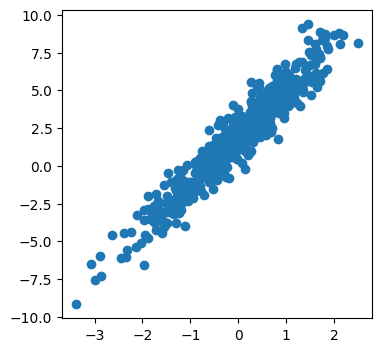

In [ ]:
plt.figure(figsize = (4,4))
plt.scatter(X,y)
plt.show();

In [ ]:
w = tf.Variable(5.)
b = tf.Variable(0.)

In [ ]:
lr = 0.03

In [ ]:
w_records = []
b_records = []
loss_records = []

for epoch in range(100):
  with tf.GradientTape() as tape:
    y_hat = X * w + b
    loss = tf.reduce_mean(tf.square(y- y_hat))

  w_records.append(w.numpy())
  b_records.append(b.numpy())
  loss_records.append(loss.numpy())

  dw, db = tape.gradient(loss, [w,b])

  w.assign_sub( lr * dw)
  b.assign_sub( lr * db)


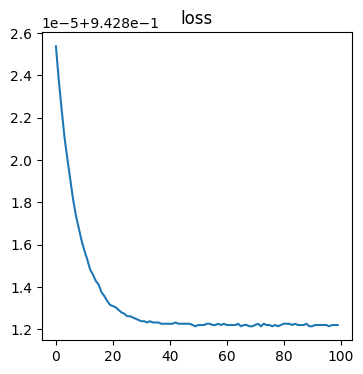

In [ ]:
plt.figure(figsize = (4,4))
plt.plot(loss_records)
plt.title('loss')
plt.show();

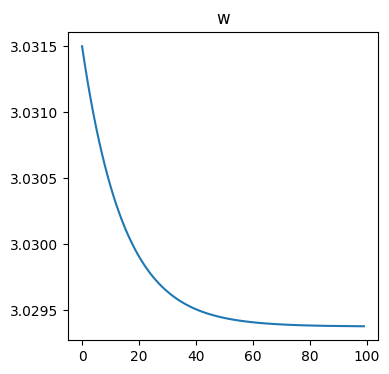

In [ ]:
plt.figure(figsize = (4,4))
plt.plot(w_records)
plt.title('w')
plt.show();

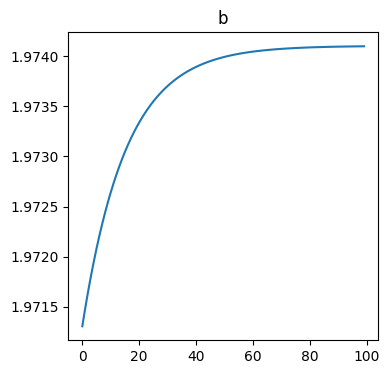

In [ ]:
plt.figure(figsize = (4,4))
plt.plot(b_records)
plt.title('b')
plt.show();

### 당뇨병 데이터

#### 가중치(1)

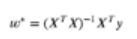

In [ ]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np

diabetes = load_diabetes()
df = pd.DataFrame(data = diabetes.data, columns = diabetes.feature_names, dtype = np.float32)
df['const'] = np.ones(df.shape[0])
df.tail()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,const
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,1.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,1.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,1.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,1.0
441,-0.045472,-0.044642,-0.073030,-0.081413,0.083740,0.027809,0.173816,-0.039493,-0.004222,0.003064,1.0


In [ ]:
X = df
y = np.expand_dims(diabetes.target, axis = 1)
X.shape, y.shape

((442, 11), (442, 1))

In [ ]:
X_t = tf.transpose(X)
w = tf.matmul(tf.matmul(tf.linalg.inv(tf.matmul(X_t , X)) , X_t) , y)

y_pred = tf.matmul(X,w)

In [ ]:
print('예측한 진행도:', y_pred[0].numpy(), '실제 진행도:', y[0])
print('예측한 진행도:', y_pred[1].numpy(), '실제 진행도:', y[1])
print('예측한 진행도:', y_pred[2].numpy(), '실제 진행도:', y[2])

예측한 진행도: [206.11667747] 실제 진행도: [151.]
예측한 진행도: [68.07103311] 실제 진행도: [75.]
예측한 진행도: [176.8827902] 실제 진행도: [141.]


#### 가중치(2)
- SGD 방식

In [ ]:
lr = 0.3
num_iter = 100

In [ ]:
 w_init = tf.random.normal((X.shape[-1],1),dtype = tf.float64)
 w = tf.Variable(w_init)

In [ ]:
for i in range(num_iter):
  with tf.GradientTape() as tape:
    y_hat = tf.matmul(X, w)
    loss = tf.reduce_mean((y-y_hat)**2)

    dw = tape.gradient(loss, w)
    w.assign_sub(lr * dw)

In [ ]:
print('예측한 진행도:', y_hat[0].numpy(), '실제 진행도:', y[0])
print('예측한 진행도:', y_hat[1].numpy(), '실제 진행도:', y[1])
print('예측한 진행도:', y_hat[2].numpy(), '실제 진행도:', y[2])

예측한 진행도: [163.08598077] 실제 진행도: [151.]
예측한 진행도: [123.23823489] 실제 진행도: [75.]
예측한 진행도: [157.4691437] 실제 진행도: [141.]


## 3.perceptron
- 이번에는 iris 데이터 중 두 종류를 분류하는 퍼셉트론을 제작
- y의 값은 1또는 -1을 사용하고 활성화 함수로는 하이퍼탄젠트 tanh를 사용한다

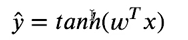

- loss 함수로는 아래 함수를 사용한다.

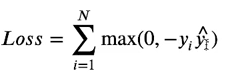

In [1]:
import tensorflow as tf
import numpy as np

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [5]:
idx = np.in1d(iris.target,[0,2]) #in1d -> target값이 0이거나 2인 값이 들어가있는지 확인하고 같은 길이의 배열을 반환
X_data = iris.data[idx,0:2]
Y_data = (iris.target[idx]-1.0)[:,np.newaxis]

In [18]:
X_data.shape, Y_data.shape

((100, 2), (100, 1))

In [19]:
X_data.dtype

dtype('float64')

- 데이터 하나당 한번씩 weight업데이트
- step size(lr) == 0.0003
- iteration == 200


---

In [38]:
lr = 0.0003
iteration = 500

In [29]:
w = tf.Variable(tf.random.normal([2,1], dtype = tf.float64 ))
b = tf.Variable(tf.random.normal([1,1], dtype = tf.float64))


In [39]:
for epoch in range(iteration):
  for i in range(X_data.shape[0]):
    x = X_data[i:i+1]
    y = Y_data[i:i+1]

    with tf.GradientTape() as tape:
      logit = tf.matmul(x,w) + b
      y_hat = tf.tanh(logit)
      loss = tf.maximum(0, tf.multiply(-y,y_hat))

      grad = tape.gradient(loss, [w,b])
      w.assign_sub(lr*grad[0])
      b.assign_sub(lr*grad[1])


In [40]:
y_pred = tf.tanh(tf.matmul(X_data, w) +b)

TensorShape([100, 1])

In [51]:
for i in range(50,60):
  print('예측치:', -1 if y_pred[i]<0 else 1, '실제값:' , Y_data[i])

예측치: 1 실제값: [1.]
예측치: 1 실제값: [1.]
예측치: 1 실제값: [1.]
예측치: 1 실제값: [1.]
예측치: 1 실제값: [1.]
예측치: 1 실제값: [1.]
예측치: 1 실제값: [1.]
예측치: 1 실제값: [1.]
예측치: 1 실제값: [1.]
예측치: 1 실제값: [1.]


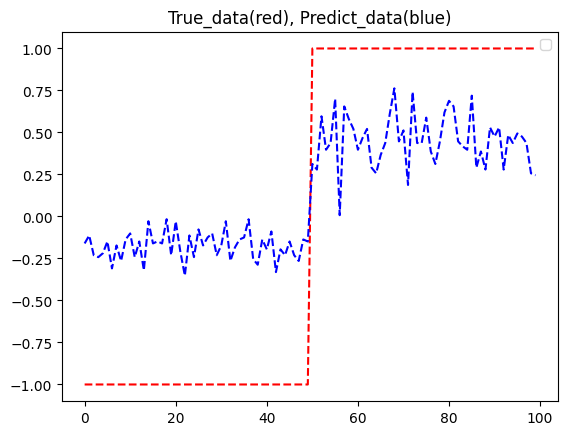

In [59]:
import matplotlib.pyplot as plt

plt.plot(Y_data, '--r')
plt.plot(y_pred, '--b')
plt.title('True_data(red), Predict_data(blue)')
plt.legend()
plt.show();
